<h1><center>Implementation of GARCH on a given stock and quantification with respect to certain metrics </center></h1>
<h2><center>LSM Invest Club - Team Quant </center></h2>
<h3><center>Jonathan - Adrien </center></h3>

In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahooquery import Ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import scipy.stats as stats


### Parameters

In [18]:
Firm = "TotalEnergies"
Ticker = "TTE"

[*********************100%***********************]  1 of 1 completed

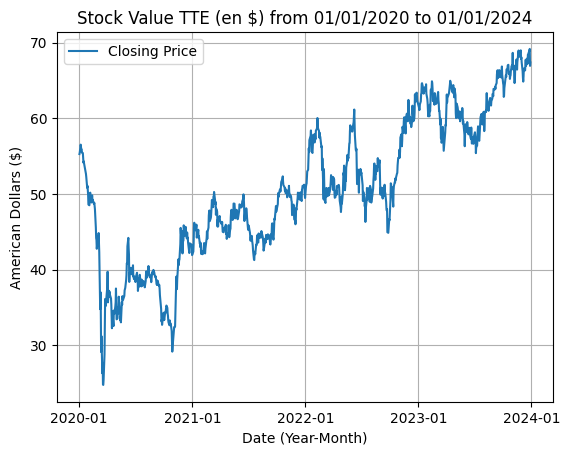

In [21]:
# Data retrieval
data = yf.download(Ticker, start='2020-01-01', end='2024-01-01')
data['Log Return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

# Illustration of TOTAL's stock price course
plt.locator_params(axis='x', nbins=4)
plt.plot(data.index, data["Close"], label="Closing Price")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Un tick par année
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel("Date (Year-Month)")
plt.ylabel("American Dollars ($)")
plt.title("Stock Value " + Ticker + " (en $) from 01/01/2020 to 01/01/2024")
plt.grid(True)
plt.legend()
plt.show()

Moyenne des log returns : 0.000464
Écart-type des log returns : 0.023796
VaR à 1% : 0.064623
ES à 1% : 0.108357
VaR à 5% : 0.031203
ES à 5% : 0.055567


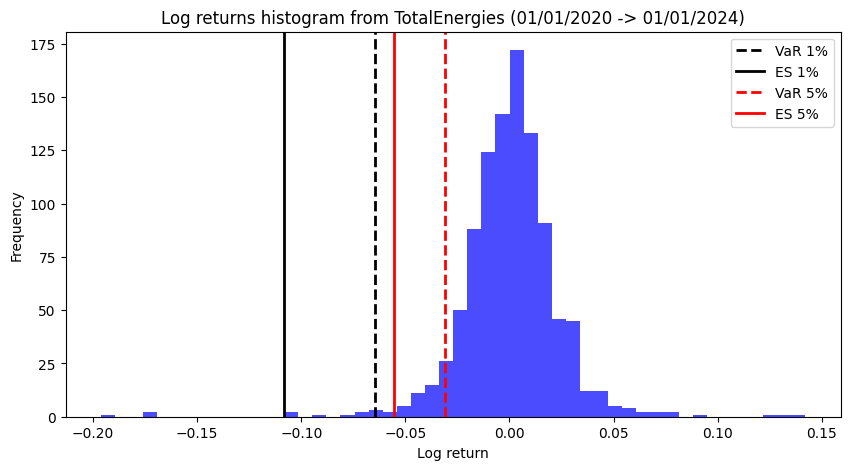

In [22]:
# Log returns analysis
log_returns = data['Log Return'].dropna()
mean_return = log_returns.mean()
std_return = log_returns.std()

# VaR 1%
confidence_level = 0.99
var_1 = log_returns.quantile(1 - confidence_level)

log_returns_pd = pd.Series(log_returns)

# ES (Expected Shortfall) 1%
ES_1 = np.mean(log_returns_pd[log_returns_pd <= var_1])

# VaR 5%
confidence_level = 0.95
var_5 = log_returns.quantile(1 - confidence_level)

# ES (Expected Shortfall) 5%
ES_5 = np.mean(log_returns_pd[log_returns_pd <= var_5])

# Results
print(f"Moyenne des log returns : {mean_return:.6f}")
print(f"Écart-type des log returns : {std_return:.6f}")
print(f"VaR à 1% : {-var_1:.6f}")
print(f"ES à 1% : {-ES_1:.6f}")
print(f"VaR à 5% : {-var_5:.6f}")
print(f"ES à 5% : {-ES_5:.6f}")

# Visualization
plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=50, alpha=0.7, color='blue')
plt.axvline(var_1, color='black', linestyle='dashed', linewidth=2, label = "VaR 1%")
plt.axvline(ES_1, color='black', linewidth=2, label = "ES 1%")
plt.axvline(var_5, color='red', linestyle='dashed', linewidth=2, label = "VaR 5%")
plt.axvline(ES_5, color='red', linewidth=2, label = "ES 5%")
plt.title('Log returns histogram from ' + Firm +  ' (01/01/2020 -> 01/01/2024)')
plt.xlabel('Log return')
plt.ylabel('Frequency')
plt.legend()
plt.show()


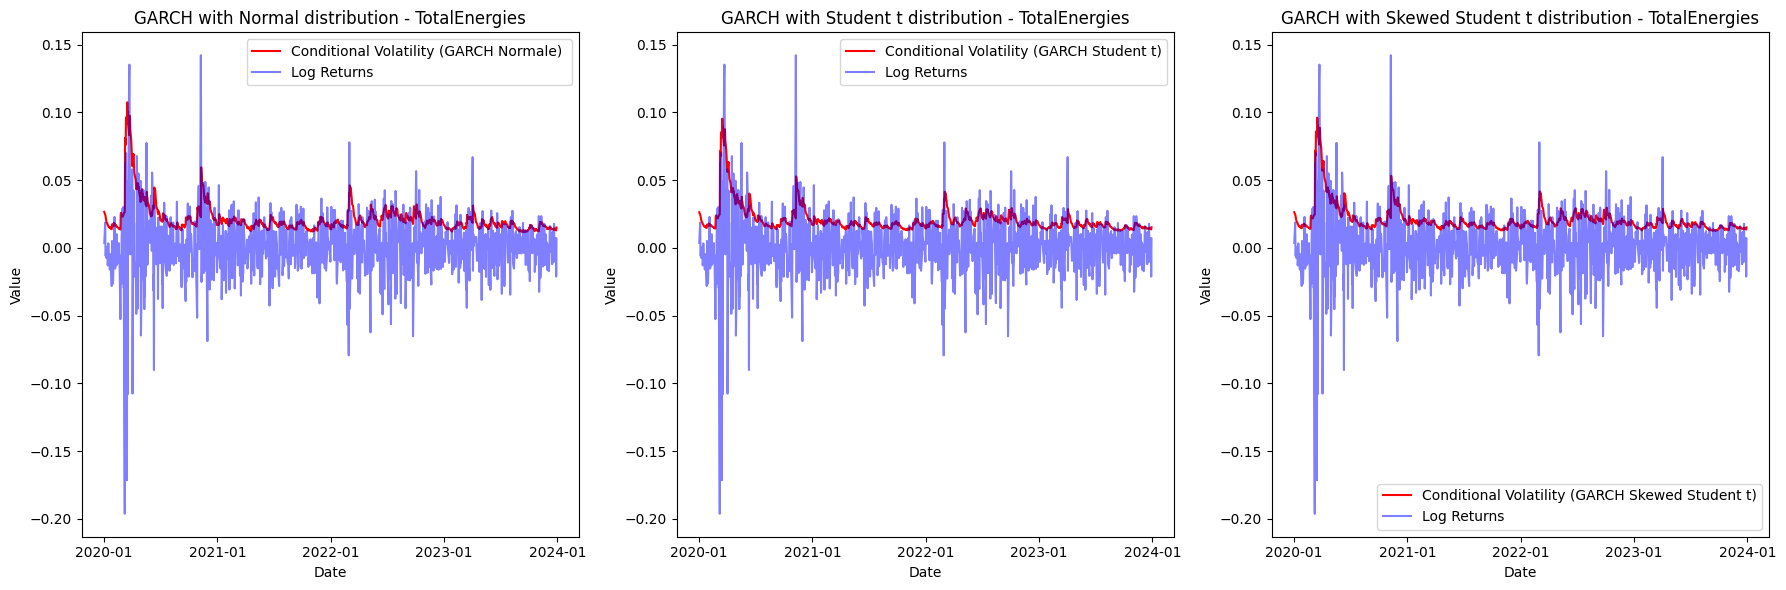

In [5]:
models = {
    'Normal': arch_model(log_returns, vol='Garch', p=1, q=1, dist='normal', rescale=True),
    'Student t': arch_model(log_returns, vol='Garch', p=1, q=1, dist='t', rescale=True),
    'Skewed Student t': arch_model(log_returns, vol='Garch', p=1, q=1, dist='skewt', rescale=True)
}

PredVol = {}
for name, model in models.items():
    garch_fit = model.fit(disp="off")
    PredVol[name] = garch_fit.conditional_volatility

plt.figure(figsize=(18, 6))

# 1. Normal GARCH
plt.subplot(1, 3, 1)
plt.plot(data.index[1:], PredVol['Normal']/100, label='Conditional Volatility (GARCH Normale) ', color='red')
plt.plot(data.index[1:], log_returns, label='Log Returns', alpha=0.5, color='blue')
plt.title(f'GARCH with Normal distribution - {Firm}')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # One tick a year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# 2. Student t GARCH
plt.subplot(1, 3, 2)
plt.plot(data.index[1:], PredVol['Student t']/100, label='Conditional Volatility (GARCH Student t)', color='red')
plt.plot(data.index[1:], log_returns, label='Log Returns', alpha=0.5, color='blue')
plt.title(f'GARCH with Student t distribution - {Firm}')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# 3. Skewed Student t GARCH
plt.subplot(1, 3, 3)
plt.plot(data.index[1:], PredVol['Skewed Student t']/100, label='Conditional Volatility (GARCH Skewed Student t)', color='red')
plt.plot(data.index[1:], log_returns, label='Log Returns', alpha=0.5, color='blue')
plt.title(f'GARCH with Skewed Student t distribution - {Firm}')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


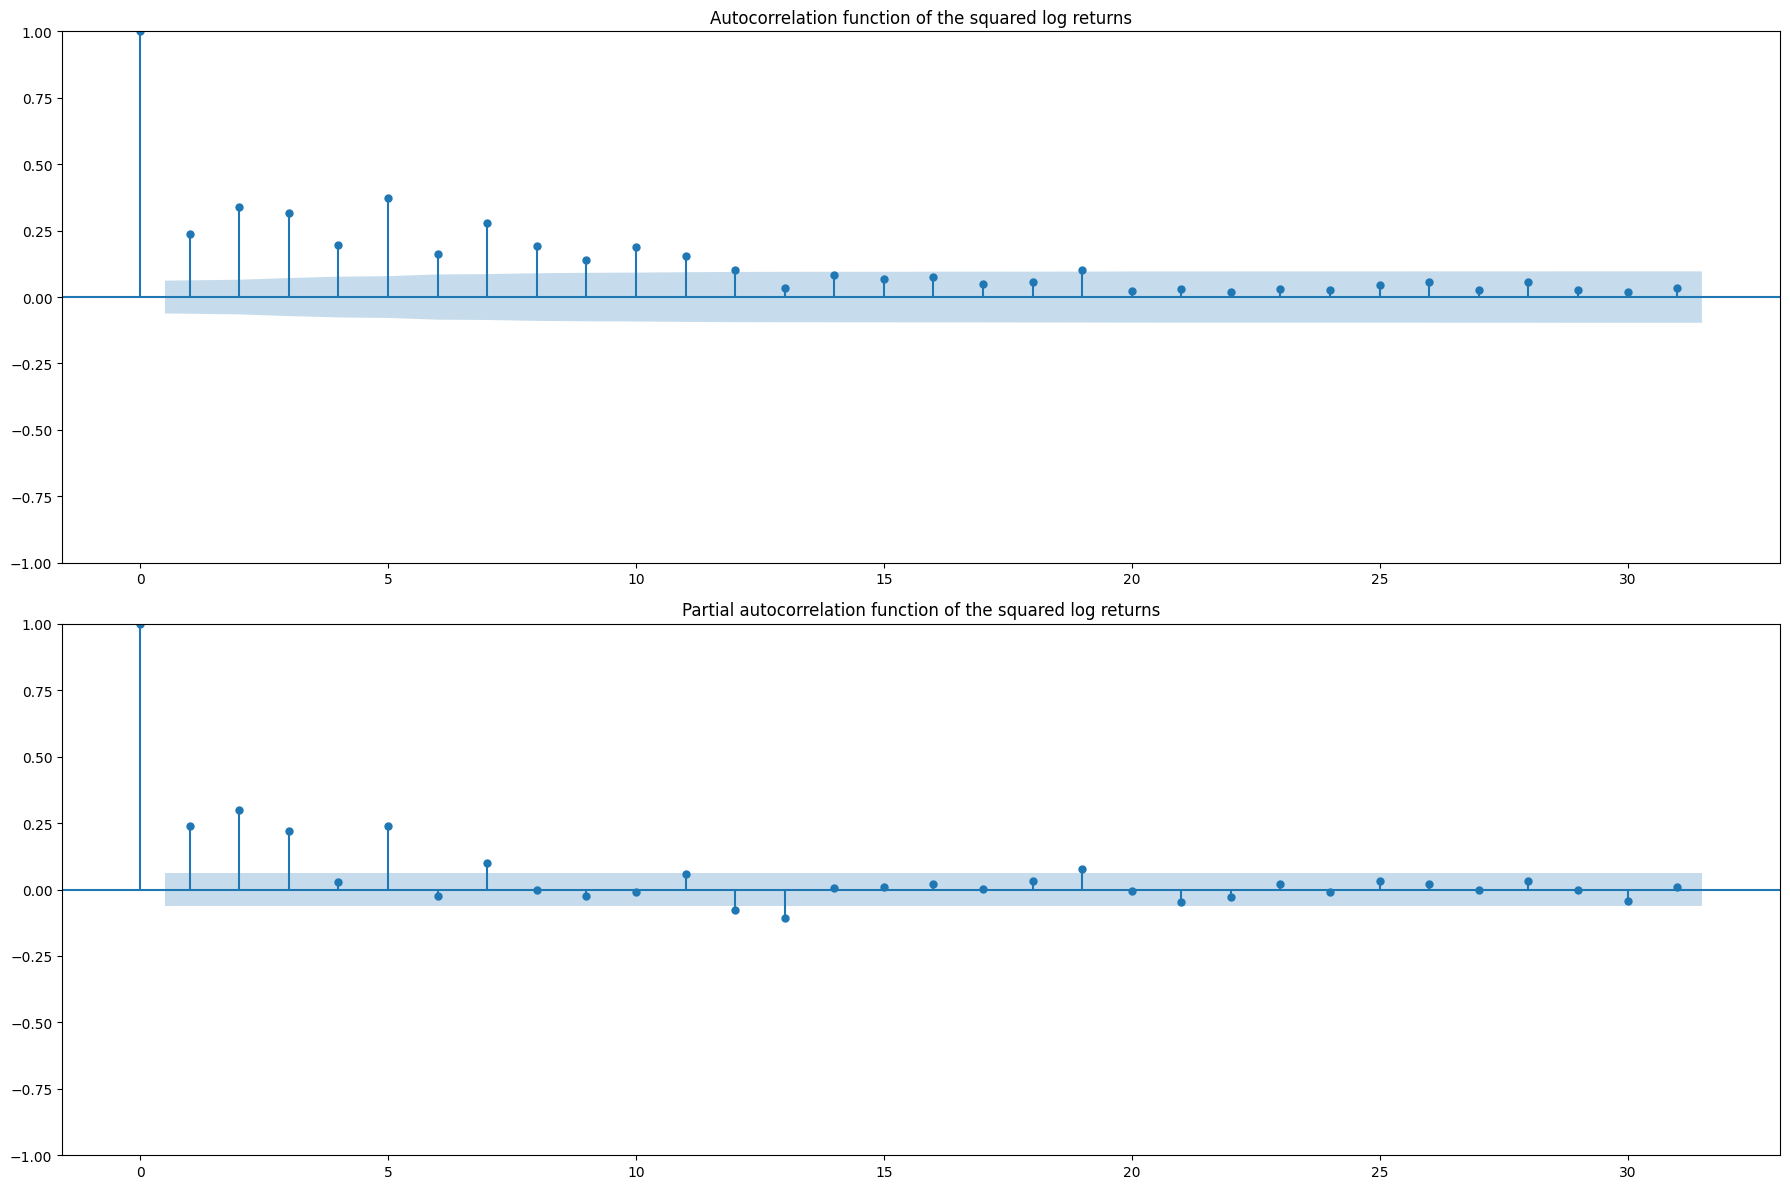

In [6]:
warnings.filterwarnings("ignore")

# Partition data by training and testing sets
train_size = int(len(log_returns) * 0.8)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]


# Plot of autocorrelation graphs 
plt.figure(figsize=(18, 12))

# Autocorrelation and partial autocorrelation of the squared log returns
plt.subplot(2, 1, 1)
plot_acf(log_returns**2, ax=plt.gca(), title="Autocorrelation function of the squared log returns")
plt.subplot(2, 1, 2)
plot_pacf(log_returns**2, ax=plt.gca(), title="Partial autocorrelation function of the squared log returns")

plt.tight_layout()
plt.show()

## Prediction based on the training percentage (0.80, 0.85, 0.9, 0.95) and the type of distribution (normal, student, skewed student)

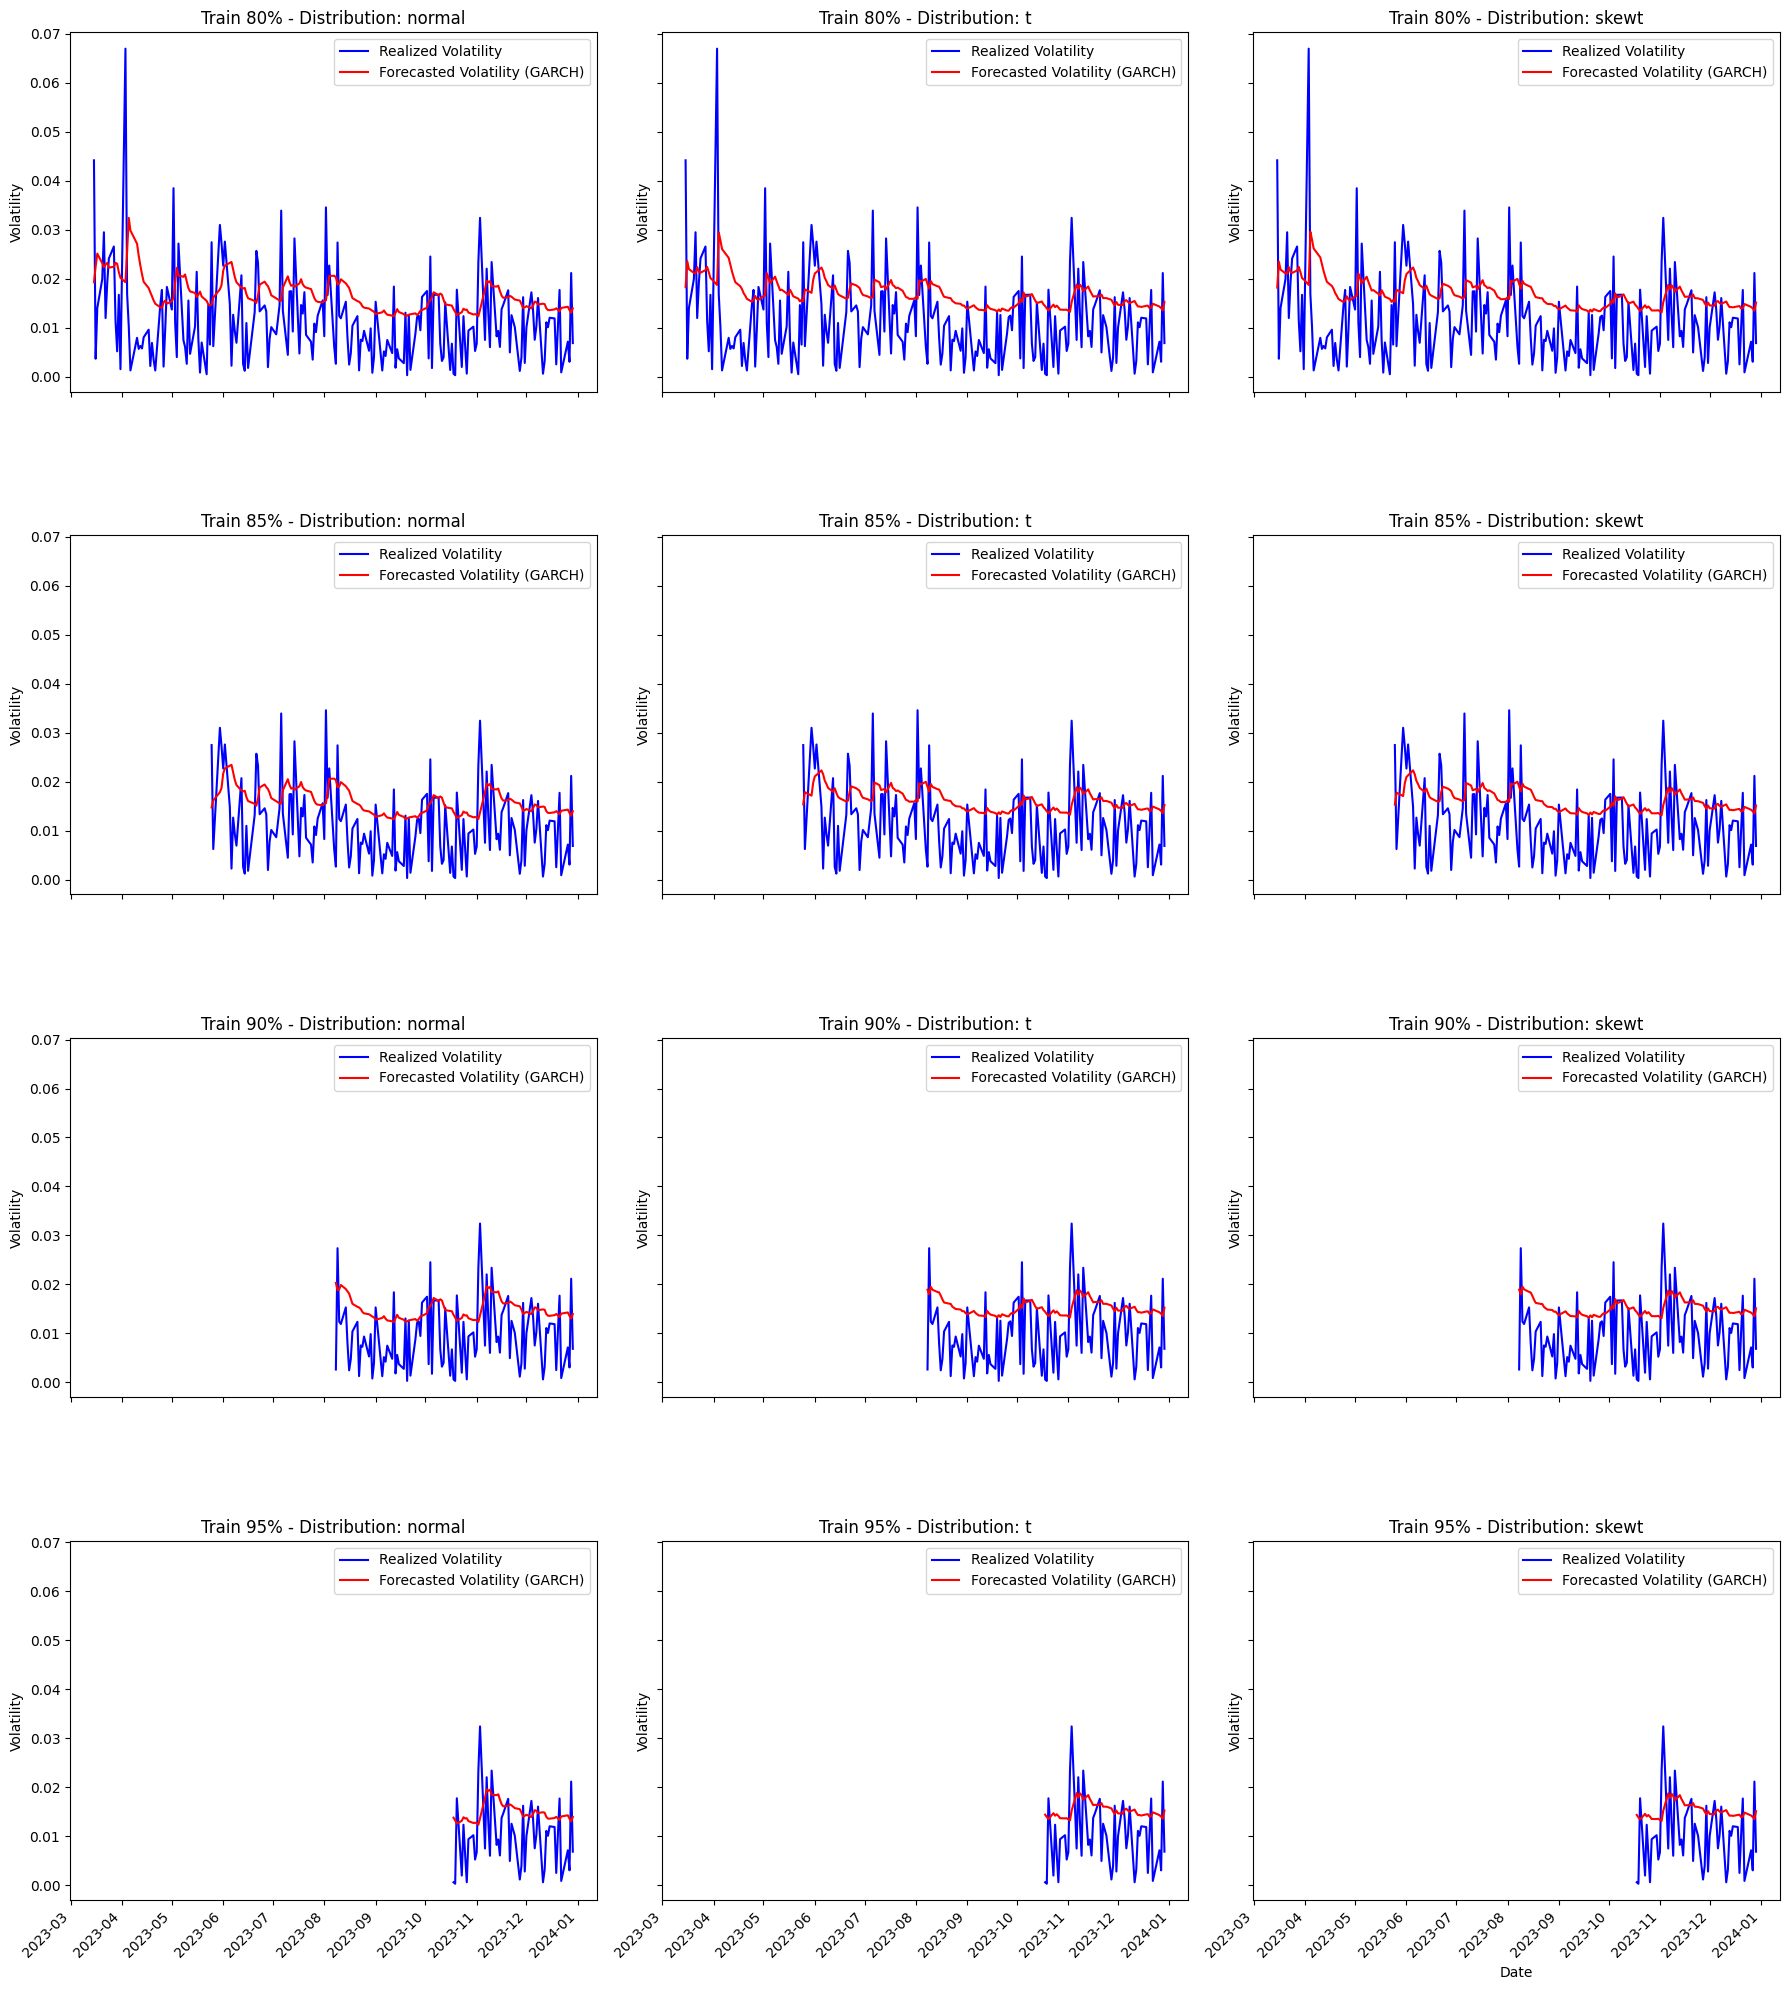

In [7]:
train_sizes = [0.8, 0.85, 0.9, 0.95]
distributions = ['normal', 't', 'skewt']
scaling_factor = 100

fig, axes = plt.subplots(len(train_sizes), 3, figsize=(18, 20), sharex=True, sharey=True)

for size_idx, train_size in enumerate(train_sizes):
    for dist_idx, dist in enumerate(distributions):
        train_split = int(len(log_returns) * train_size)
        train_data = log_returns[:train_split]
        test_data = log_returns[train_split:]

        scaled_train_data = train_data * scaling_factor
        scaled_test_data = test_data * scaling_factor

        best_aic = np.inf
        best_order = None
        best_model = None

        for p in range(1, 3):
            for q in range(1, 3):
                try:
                    model = arch_model(scaled_train_data, vol='Garch', p=p, q=q, dist=dist)
                    model_fit = model.fit(disp='off')
                    aic = model_fit.aic
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, q)
                        best_model = model_fit
                except Exception as e:
                    continue

        rolling_predictions = []
        history = list(scaled_train_data)

        for t in range(len(scaled_test_data)):
            model = arch_model(history, vol='Garch', p=best_order[0], q=best_order[1], dist=dist)
            model_fit = model.fit(disp='off')
            pred = model_fit.forecast(horizon=1)
            predicted_volatility = np.sqrt(pred.variance.values[-1, :][0])
            rolling_predictions.append(predicted_volatility)
            history.append(scaled_test_data[t])

        rolling_predictions = np.array(rolling_predictions) / scaling_factor
        realized_volatility = np.abs(test_data)

        # Visualization in the good subplot
        ax = axes[size_idx, dist_idx]
        ax.plot(test_data.index, realized_volatility, label='Realized Volatility', color='blue')
        ax.plot(test_data.index, rolling_predictions, label='Forecasted Volatility (GARCH)', color='red')

        # Graph configuration
        ax.set_title(f'Train {int(train_size * 100)}% - Distribution: {dist}')
        ax.set_ylabel('Volatility')
        ax.legend()
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.xlabel('Date')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

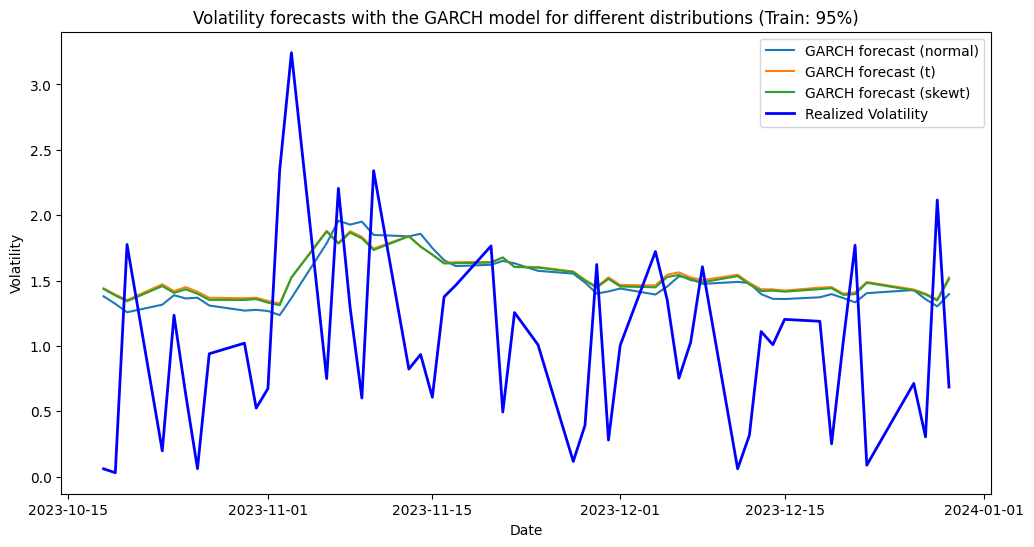

In [8]:
all_rolling_predictions = []
train_size_ratio = 0.95

train_size = int(len(log_returns) * train_size_ratio)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]

scaling_factor = 100
scaled_train_data = train_data * scaling_factor
scaled_test_data = test_data * scaling_factor

distributions = ['normal', 't', 'skewt']
best_orders = []
for dist in distributions:
    best_aic = np.inf
    best_order = None

    for p in range(1, 3):
        for q in range(1, 3):
            try:
                model = arch_model(scaled_train_data, vol='Garch', p=p, q=q, dist=dist)
                model_fit = model.fit(disp='off')
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, q)
            except Exception as e:
                continue
    best_orders.append(best_order)
    rolling_predictions = []
    history = list(scaled_train_data)

    for t in range(len(scaled_test_data)):
        model = arch_model(history, vol='Garch', p=best_order[0], q=best_order[1], dist=dist)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        predicted_volatility = np.sqrt(pred.variance.values[-1, :][0])
        rolling_predictions.append(predicted_volatility)
        history.append(scaled_test_data[t])

    rolling_predictions = np.array(rolling_predictions)
    all_rolling_predictions.append(rolling_predictions)

realized_volatility = np.abs(test_data) * scaling_factor

plt.figure(figsize=(12, 6))

for idx, predictions in enumerate(all_rolling_predictions):
    plt.plot(test_data.index[:len(predictions)], predictions, label=f'GARCH forecast ({distributions[idx]})')

plt.plot(test_data.index, realized_volatility, label='Realized Volatility', color='blue', linewidth=2)
plt.title('Volatility forecasts with the GARCH model for different distributions (Train: 95%)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


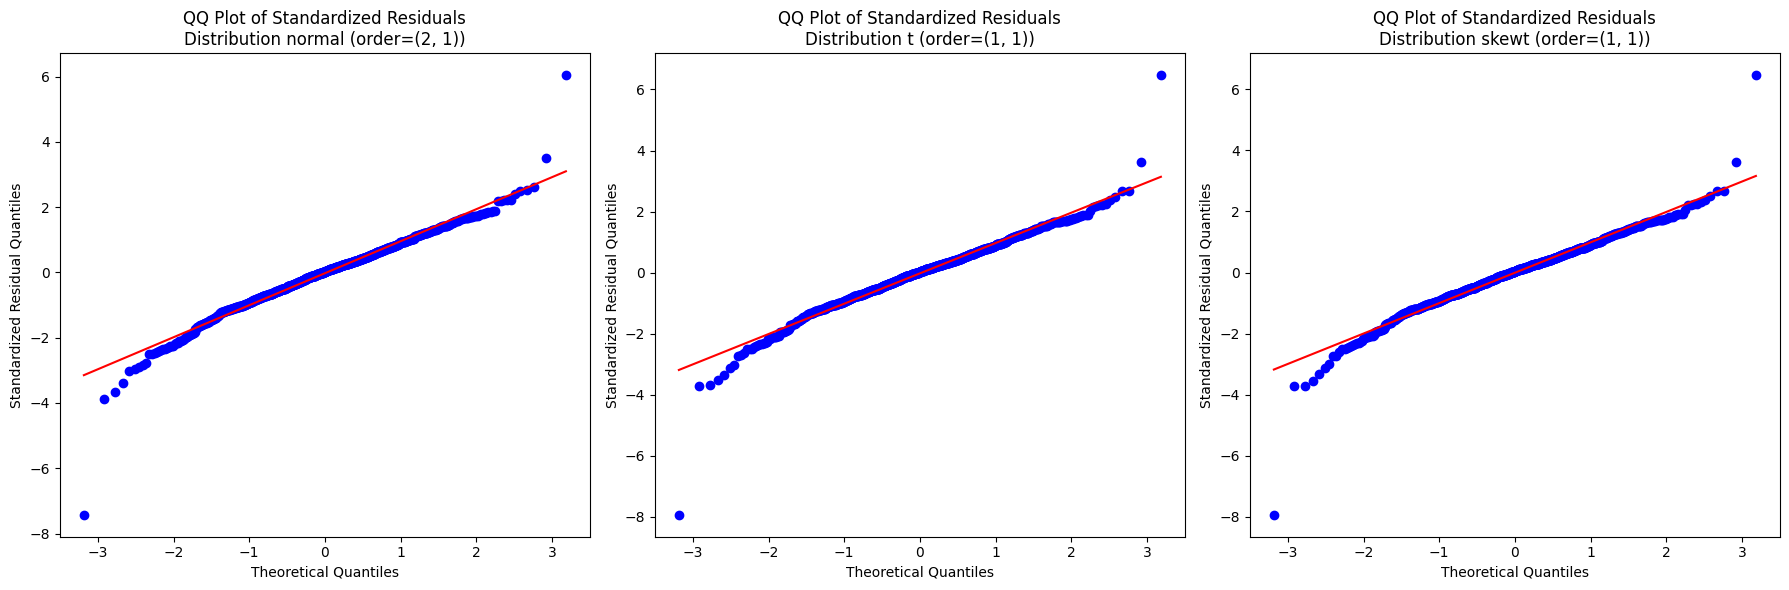

In [9]:
# Create a figure to display the QQ plots side by side
plt.figure(figsize=(18, 6))  # Increased width to accommodate the plots side by side

# Loop to compute and display the QQ plot for each distribution
for idx, dist in enumerate(distributions):
    # Best order found for the current distribution
    best_order = best_orders[idx]

    # Fit the model with the best parameters on the training data
    model = arch_model(scaled_train_data, vol='Garch', p=best_order[0], q=best_order[1], dist=dist)
    model_fit = model.fit(disp='off')

    # Calculate the standardized residuals
    standardized_residuals = model_fit.std_resid

    # Create the QQ plot in a subplot
    plt.subplot(1, len(distributions), idx + 1)  # 1 row, number of columns = number of distributions
    stats.probplot(standardized_residuals, dist="norm", plot=plt)
    plt.title(f"QQ Plot of Standardized Residuals\nDistribution {dist} (order={best_order})")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Standardized Residual Quantiles")

# Adjust display and final showing
plt.tight_layout()
plt.show()

## QQPlot corrections, better when switching to T distributions, especially if we remove outliers, but there is still an issue with the points on the left, needs inspection.

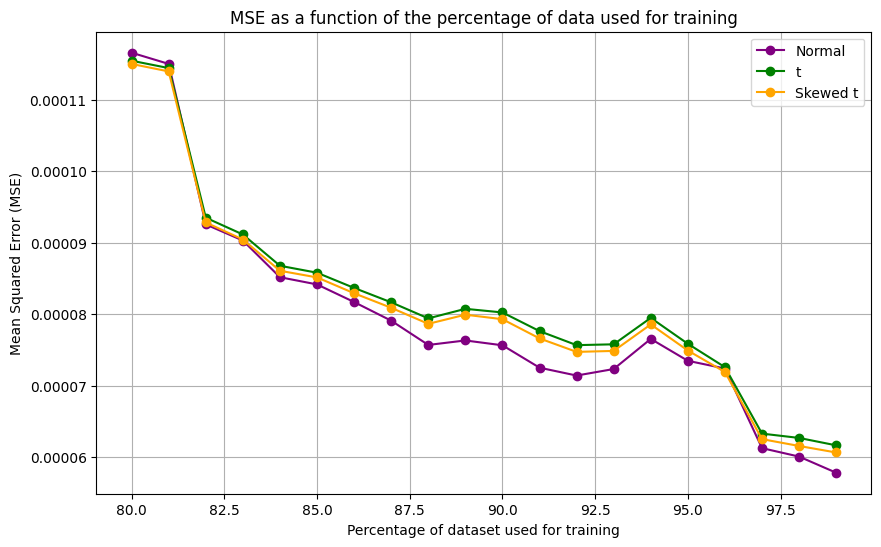

In [10]:
from sklearn.metrics import mean_squared_error
mse_values_normal = []
mse_values_t = []
mse_values_skewt = []
train_sizes = np.linspace(0.80, 0.99, 20)

for train_size_ratio in train_sizes:
    best_aic = np.inf
    p, q = None, None

    train_size = int(len(log_returns) * train_size_ratio)
    train_data = log_returns[:train_size]
    test_data = log_returns[train_size:]

    scaled_train_data = train_data * scaling_factor
    scaled_test_data = test_data * scaling_factor

    for dist in ['normal', 't', 'skewt']:
    
        best_aic = np.inf
        for ptest in range(1, 4):
            for qtest in range(1, 4):
                try:
                    model = arch_model(scaled_train_data, vol='Garch', p=ptest, q=qtest, dist=dist)
                    model_fit = model.fit(disp='off')
                    aic = model_fit.aic
                    if aic < best_aic:
                        p = ptest
                        q = qtest
                except Exception as e:
                    continue

        rolling_predictions = []
        history = list(scaled_train_data)

        for t in range(len(scaled_test_data)):
            model = arch_model(history, vol='Garch', p=p, q=q, dist=dist)
            model_fit = model.fit(disp='off')
            pred = model_fit.forecast(horizon=1)
            predicted_volatility = np.sqrt(pred.variance.values[-1, :][0])
            rolling_predictions.append(predicted_volatility)
            history.append(scaled_test_data[t])

        rolling_predictions = np.array(rolling_predictions) / scaling_factor
        realized_volatility = np.abs(test_data)

        root_mse = mean_squared_error(realized_volatility, rolling_predictions)
        if dist == 'normal':
            mse_values_normal.append(root_mse)
        elif dist == 't':
            mse_values_t.append(root_mse)
        elif dist == 'skewt':
            mse_values_skewt.append(root_mse)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * 100, mse_values_normal, marker='o', color='purple', label='Normal')
plt.plot(train_sizes * 100, mse_values_t, marker='o', color='green', label='t')
plt.plot(train_sizes * 100, mse_values_skewt, marker='o', color='orange', label='Skewed t')
plt.title("MSE as a function of the percentage of data used for training")
plt.xlabel("Percentage of dataset used for training")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.legend()
plt.show()


### Other metrics:
Directional Accuracy for upward or downward movements

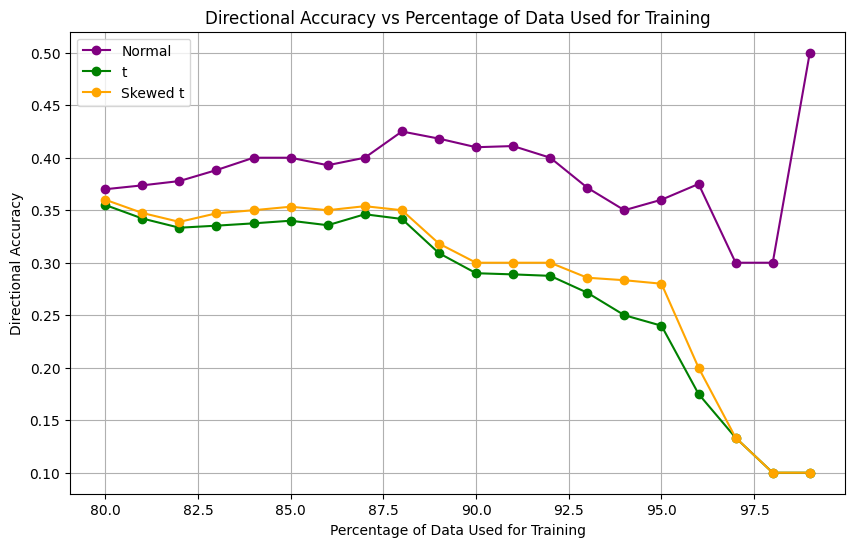

In [11]:
from sklearn.metrics import accuracy_score

accuracy_values_normal = []
accuracy_values_t = []
accuracy_values_skewt = []
train_sizes = np.linspace(0.80, 0.99, 20)

for train_size_ratio in train_sizes:
    best_aic = np.inf
    p, q = None, None

    train_size = int(len(log_returns) * train_size_ratio)
    train_data = log_returns[:train_size]
    test_data = log_returns[train_size:]

    scaled_train_data = train_data * scaling_factor
    scaled_test_data = test_data * scaling_factor

    for dist in ['normal', 't', 'skewt']:
        best_aic = np.inf
        for ptest in range(1, 4):
            for qtest in range(1, 4):
                try:
                    model = arch_model(scaled_train_data, vol='Garch', p=ptest, q=qtest, dist=dist)
                    model_fit = model.fit(disp='off')
                    aic = model_fit.aic
                    if aic < best_aic:
                        p = ptest
                        q = qtest
                except Exception as e:
                    continue

        rolling_predictions = []
        history = list(scaled_train_data)

        for t in range(len(scaled_test_data)):
            model = arch_model(history, vol='Garch', p=p, q=q, dist=dist)
            model_fit = model.fit(disp='off')
            pred = model_fit.forecast(horizon=1)
            predicted_volatility = np.sqrt(pred.variance.values[-1, :][0])
            rolling_predictions.append(predicted_volatility)
            history.append(scaled_test_data[t])

        rolling_predictions = np.array(rolling_predictions) / scaling_factor
        realized_volatility = np.abs(test_data)

        # Calculate direction accuracy
        direction_realized = np.sign(np.diff(realized_volatility))
        direction_predicted = np.sign(np.diff(rolling_predictions))
        direction_accuracy = accuracy_score(direction_realized, direction_predicted)

        if dist == 'normal':
            accuracy_values_normal.append(direction_accuracy)
        elif dist == 't':
            accuracy_values_t.append(direction_accuracy)
        elif dist == 'skewt':
            accuracy_values_skewt.append(direction_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * 100, accuracy_values_normal, marker='o', color='purple', label='Normal')
plt.plot(train_sizes * 100, accuracy_values_t, marker='o', color='green', label='t')
plt.plot(train_sizes * 100, accuracy_values_skewt, marker='o', color='orange', label='Skewed t')
plt.title("Directional Accuracy vs Percentage of Data Used for Training")
plt.xlabel("Percentage of Data Used for Training")
plt.ylabel("Directional Accuracy")
plt.grid(True)
plt.legend()
plt.show()


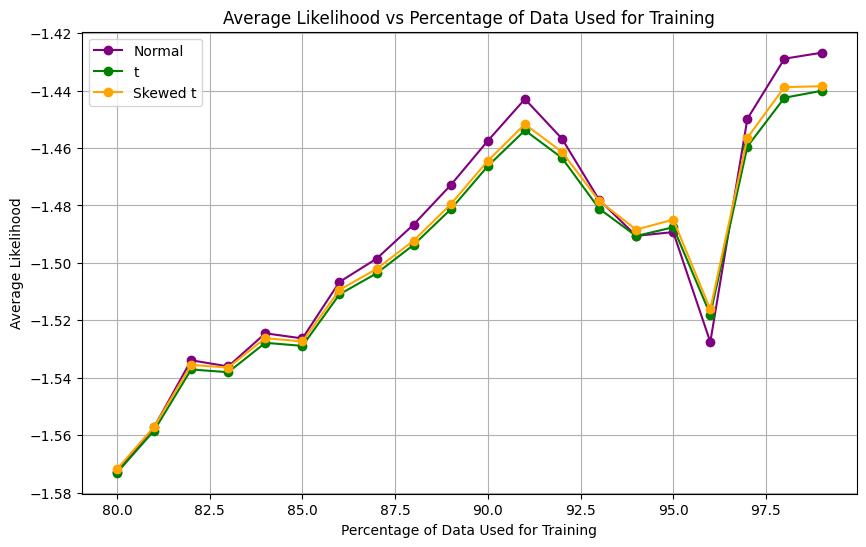

In [12]:
from scipy.stats import t as t_dist
from scipy.stats import norm
likelihood_values_normal = []
likelihood_values_t = []
likelihood_values_skewt = []

train_sizes = np.linspace(0.80, 0.99, 20)

for train_size_ratio in train_sizes:
    best_aic = np.inf
    p, q = None, None

    train_size = int(len(log_returns) * train_size_ratio)
    train_data = log_returns[:train_size]
    test_data = log_returns[train_size:]

    scaled_train_data = train_data * scaling_factor
    scaled_test_data = test_data * scaling_factor

    for dist in ['normal', 't', 'skewt']:
        best_aic = np.inf
        best_model_fit = None
        for ptest in range(1, 4):
            for qtest in range(1, 4):
                try:
                    model = arch_model(scaled_train_data, vol='Garch', p=ptest, q=qtest, dist=dist)
                    model_fit = model.fit(disp='off')
                    aic = model_fit.aic
                    if aic < best_aic:
                        best_aic = aic
                        best_model_fit = model_fit
                        p, q = ptest, qtest
                except Exception as e:
                    continue

        likelihood_sum = 0
        history = list(scaled_train_data)

        for t in range(len(scaled_test_data)):
            model = arch_model(history, vol='Garch', p=p, q=q, dist=dist)
            model_fit = model.fit(disp='off')
            pred = model_fit.forecast(horizon=1)
            predicted_volatility = np.sqrt(pred.variance.values[-1, :][0])
            standardized_residual = (scaled_test_data[t] - model_fit.params['mu']) / predicted_volatility
            
            if dist == 'normal':
                likelihood_sum += norm.logpdf(standardized_residual, loc=0, scale=predicted_volatility)
            elif dist == 't':
                likelihood_sum += t_dist.logpdf(standardized_residual, df=803, scale=predicted_volatility)
            elif dist == 'skewt':
                likelihood_sum += t_dist.logpdf(standardized_residual, df=803, scale=predicted_volatility)

            history.append(scaled_test_data[t])
        
        avg_likelihood = likelihood_sum / len(scaled_test_data)
        
        if dist == 'normal':
            likelihood_values_normal.append(avg_likelihood)
        elif dist == 't':
            likelihood_values_t.append(avg_likelihood)
        elif dist == 'skewt':
            likelihood_values_skewt.append(avg_likelihood)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * 100, likelihood_values_normal, marker='o', color='purple', label='Normal')
plt.plot(train_sizes * 100, likelihood_values_t, marker='o', color='green', label='t')
plt.plot(train_sizes * 100, likelihood_values_skewt, marker='o', color='orange', label='Skewed t')
plt.title("Average Likelihood vs Percentage of Data Used for Training")
plt.xlabel("Percentage of Data Used for Training")
plt.ylabel("Average Likelihood")
plt.grid(True)
plt.legend()
plt.show()


The average likelihood is a measure that evaluates how well the model fits the observed data. The higher the likelihood, the better the model explains the data.

- For each observation in the test data (`scaled_test_data`), the GARCH model predicts the Conditional Volatility for the next day.
- The difference between the observed value and the mean (`mu` of the model) is divided by the predicted Volatility to obtain the **standardized residual**.
- The likelihood of the standardized residual is calculated using the probability density function (log-pdf) of the chosen distribution (normal, Student’s t, or skewed t).
- This likelihood score is added to the total likelihood (`likelihood_sum`), accumulating the likelihood of each prediction in the test data.

Once all likelihoods are calculated, the average likelihood is obtained by dividing `likelihood_sum` by the number of observations in the test set.

# Percentage of error at each timestep

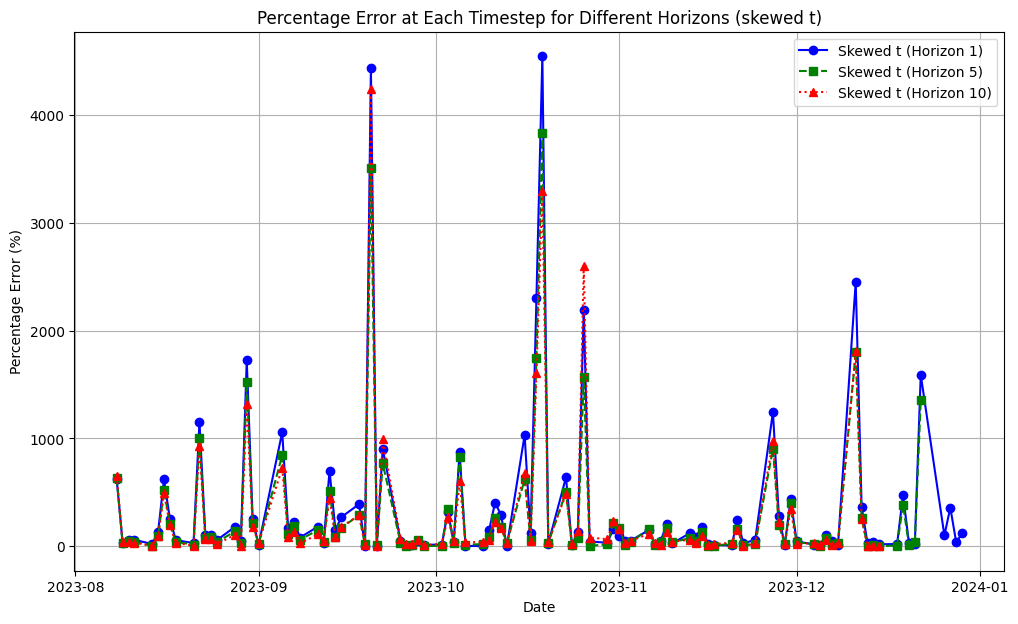

In [13]:
horizons = [1, 5, 10]  # Defines the forecasting horizons in days
percentage_errors_horizons_skewt = {h: [] for h in horizons}

# Training size
train_size_ratio = 0.90
train_size = int(len(log_returns) * train_size_ratio)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]
scaled_train_data = train_data * scaling_factor
scaled_test_data = test_data * scaling_factor

# Optimal parameters for the 'skewt' distribution
best_aic = np.inf
best_order = (1, 1)

# Search for the best parameters (p, q)
for p in range(1, 4):
    for q in range(1, 4):
        try:
            model = arch_model(scaled_train_data, vol='Garch', p=p, q=q, dist='skewt')
            model_fit = model.fit(disp='off')
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, q)
        except Exception as e:
            continue

# Calculating percentage errors for each horizon
for h in horizons:
    rolling_predictions = []
    history = list(scaled_train_data)

    for t in range(len(scaled_test_data) - h + 1):
        model = arch_model(history, vol='Garch', p=best_order[0], q=best_order[1], dist='skewt')
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=h)
        predicted_volatility = np.sqrt(pred.variance.values[-1, :]).mean()  # Mean over the horizon
        rolling_predictions.append(predicted_volatility)
        history.extend(scaled_test_data[t:t+h])  # Update history with the horizon

    # Calculating the percentage error for the given horizon
    rolling_predictions = np.array(rolling_predictions) / scaling_factor
    realized_volatility = np.abs(test_data[:len(rolling_predictions)])
    percentage_errors = np.abs((realized_volatility - rolling_predictions) / realized_volatility) * 100

    # Storing the errors for plotting
    percentage_errors_horizons_skewt[h] = percentage_errors

# Plotting percentage errors for each horizon on a single graph with different styles
plt.figure(figsize=(12, 7))
styles = {1: ('-', 'o', 'blue'), 5: ('--', 's', 'green'), 10: (':', '^', 'red')}
for h in horizons:
    line_style, marker, color = styles[h]
    plt.plot(test_data.index[:len(percentage_errors_horizons_skewt[h])], 
             percentage_errors_horizons_skewt[h], linestyle=line_style, marker=marker, color=color,
             label=f'Skewed t (Horizon {h})')

plt.title("Percentage Error at Each Timestep for Different Horizons (skewed t)")
plt.xlabel("Date")
plt.ylabel("Percentage Error (%)")
plt.legend()
plt.grid(True)
plt.show()


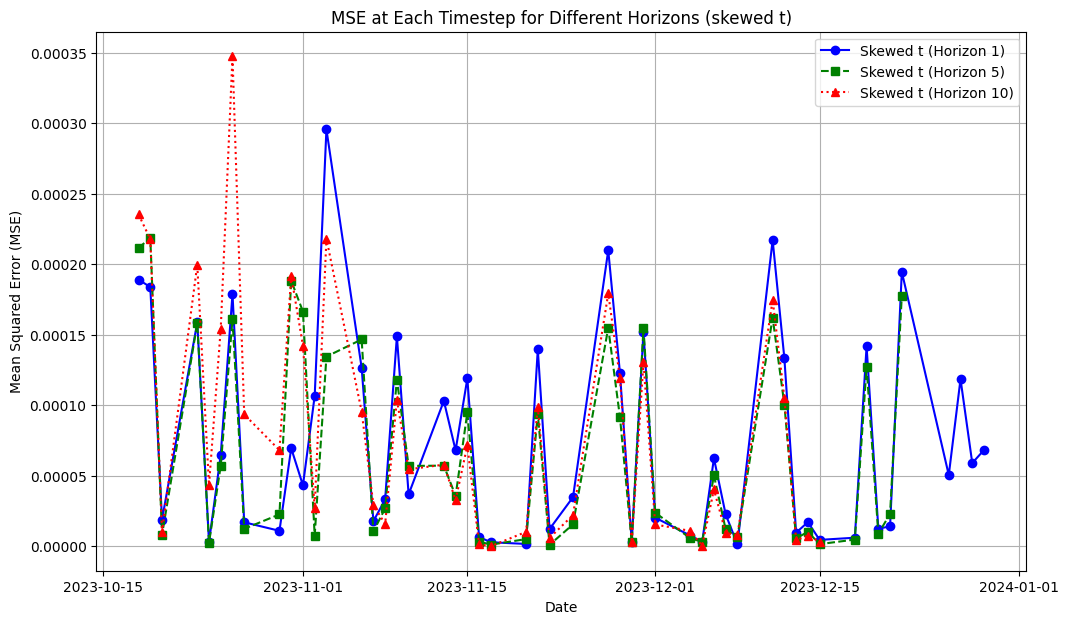

In [14]:
from sklearn.metrics import mean_squared_error

horizons = [1, 5, 10]  # Defines the forecasting horizons in days
mse_horizons_skewt = {h: [] for h in horizons}

# Training size
train_size_ratio = 0.95
train_size = int(len(log_returns) * train_size_ratio)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]
scaled_train_data = train_data * scaling_factor
scaled_test_data = test_data * scaling_factor

# Optimal parameters for the 'skewt' distribution
best_aic = np.inf
best_order = (1, 1)

# Searching for the best parameters (p, q)
for p in range(1, 4):
    for q in range(1, 4):
        try:
            model = arch_model(scaled_train_data, vol='Garch', p=p, q=q, dist='skewt')
            model_fit = model.fit(disp='off')
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, q)
        except Exception as e:
            continue

# Calculating MSE for each horizon
for h in horizons:
    rolling_predictions = []
    history = list(scaled_train_data)

    for t in range(len(scaled_test_data) - h + 1):
        model = arch_model(history, vol='Garch', p=best_order[0], q=best_order[1], dist='skewt')
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=h)
        predicted_volatility = np.sqrt(pred.variance.values[-1, :]).mean()  # Mean over the horizon
        rolling_predictions.append(predicted_volatility)
        history.extend(scaled_test_data[t:t+h])  # Update history with the horizon

    # Converting predictions to array for each horizon
    rolling_predictions = np.array(rolling_predictions) / scaling_factor
    realized_volatility = np.abs(test_data[:len(rolling_predictions)])
    
    # Calculating MSE at each timestep for this horizon
    mse_values = (realized_volatility - rolling_predictions) ** 2
    mse_horizons_skewt[h] = mse_values  # Storing MSE for each timestep

# Plotting MSE for each horizon on a single graph with different styles
plt.figure(figsize=(12, 7))
styles = {1: ('-', 'o', 'blue'), 5: ('--', 's', 'green'), 10: (':', '^', 'red')}
for h in horizons:
    line_style, marker, color = styles[h]
    plt.plot(test_data.index[:len(mse_horizons_skewt[h])], 
             mse_horizons_skewt[h], linestyle=line_style, marker=marker, color=color,
             label=f'Skewed t (Horizon {h})')

plt.title("MSE at Each Timestep for Different Horizons (skewed t)")
plt.xlabel("Date")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.show()


## Exponential GARCH

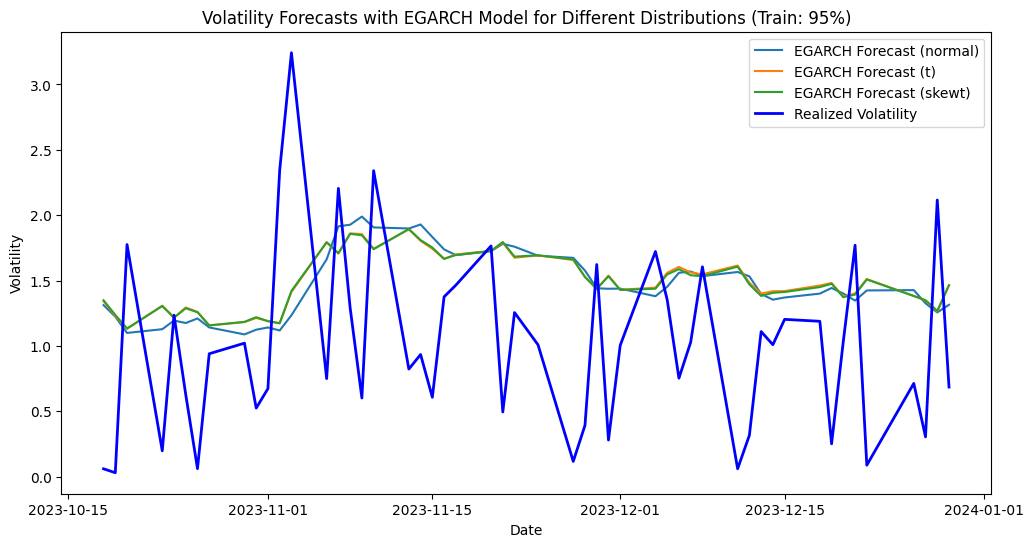

In [15]:
from arch import arch_model
import numpy as np
import matplotlib.pyplot as plt

all_rolling_predictions = []
train_size_ratio = 0.95

train_size = int(len(log_returns) * train_size_ratio)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]

scaling_factor = 100
scaled_train_data = train_data * scaling_factor
scaled_test_data = test_data * scaling_factor

distributions = ['normal', 't', 'skewt']
best_orders = []

for dist in distributions:
    best_aic = np.inf
    best_order = None

    for p in range(1, 3):
        for q in range(1, 3):
            try:
                # EGARCH model implementation
                model = arch_model(scaled_train_data, vol='EGarch', p=p, q=q, dist=dist)
                model_fit = model.fit(disp='off')
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, q)
            except Exception as e:
                continue

    best_orders.append(best_order)
    rolling_predictions = []
    history = list(scaled_train_data)

    for t in range(len(scaled_test_data)):
        model = arch_model(history, vol='EGarch', p=best_order[0], q=best_order[1], dist=dist)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        predicted_volatility = np.sqrt(pred.variance.values[-1, :][0])
        rolling_predictions.append(predicted_volatility)
        history.append(scaled_test_data[t])

    rolling_predictions = np.array(rolling_predictions)
    all_rolling_predictions.append(rolling_predictions)

realized_volatility = np.abs(test_data) * scaling_factor

plt.figure(figsize=(12, 6))

for idx, predictions in enumerate(all_rolling_predictions):
    plt.plot(test_data.index[:len(predictions)], predictions, label=f'EGARCH Forecast ({distributions[idx]})')

plt.plot(test_data.index, realized_volatility, label='Realized Volatility', color='blue', linewidth=2)
plt.title('Volatility Forecasts with EGARCH Model for Different Distributions (Train: 95%)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


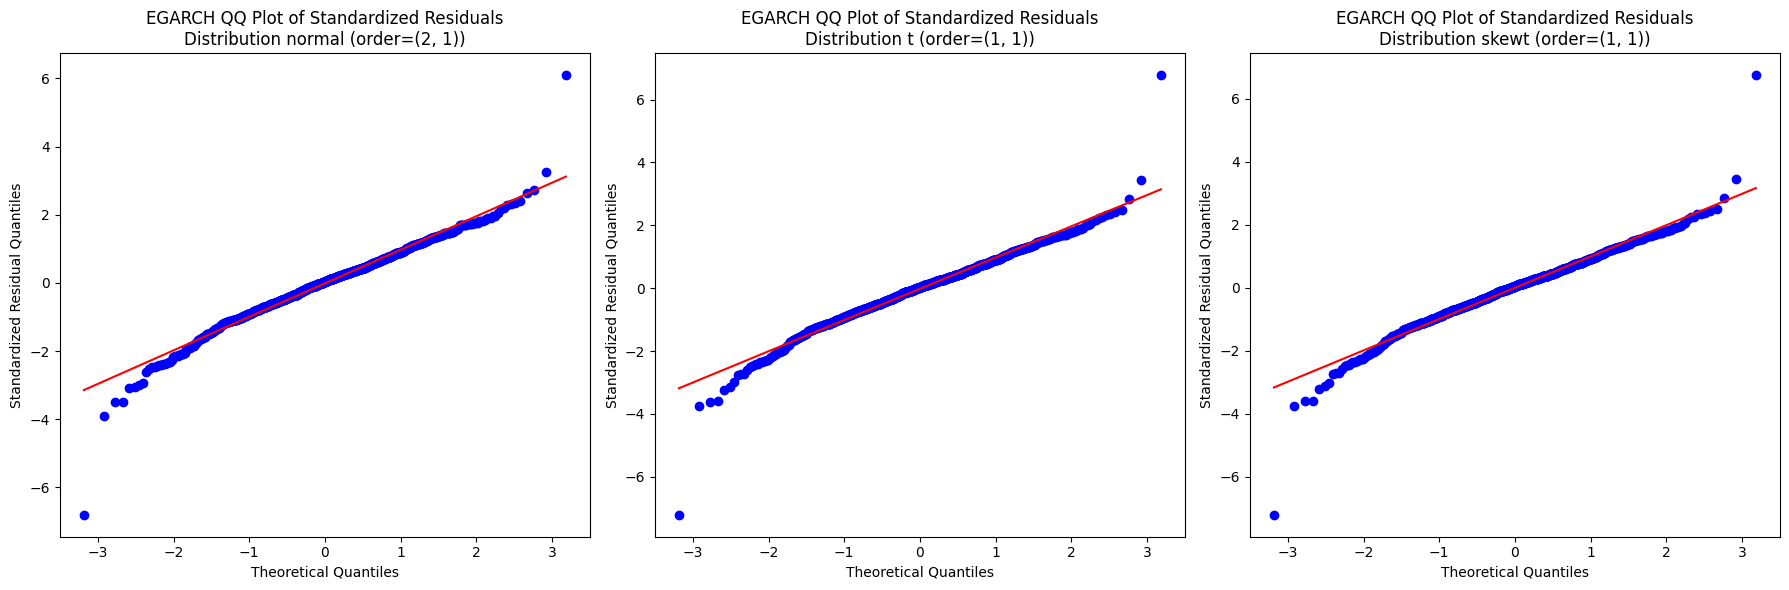

In [16]:
# Create a figure to display the QQ plots side by side
plt.figure(figsize=(18, 6))  # Increased width to accommodate the plots side by side

# Loop to calculate and display the QQ plot for each distribution
for idx, dist in enumerate(distributions):
    # Best order found for the current distribution
    best_order = best_orders[idx]

    # Fit the EGARCH model with the best parameters on the training data
    model = arch_model(scaled_train_data, vol='EGarch', p=best_order[0], q=best_order[1], dist=dist)
    model_fit = model.fit(disp='off')

    # Calculate the standardized residuals
    standardized_residuals = model_fit.std_resid

    # Create the QQ plot in a subplot
    plt.subplot(1, len(distributions), idx + 1)  # 1 row, number of columns = number of distributions
    stats.probplot(standardized_residuals, dist="norm", plot=plt)
    plt.title(f"EGARCH QQ Plot of Standardized Residuals\nDistribution {dist} (order={best_order})")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Standardized Residual Quantiles")

# Adjust layout and show the final plot
plt.tight_layout()
plt.show()